In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

# GDP data reading and cleaning

In [2]:
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)

C:\Users\sidhu\AppData\Local\Temp/ipykernel_12264/3962260804.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(gdp_path)


In [3]:
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp.head(2)

,REF_DATE,GEO,DGUID,Prices,Seasonal adjustment,Estimates,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Final consumption expenditure,Dollars,81,millions,6,v62305723,1.1.1.1,273818.0,NaN,NaN,NaN,0
1,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Household final consumption expenditure,Dollars,81,millions,6,v62305724,1.1.1.2,182300.0,NaN,NaN,NaN,0


### Extracted only required columns and rows

In [4]:
# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})

In [7]:
gdpts.head()

,Date,GDP
31505,2004-01-01,1566737.0
31688,2004-04-01,1585347.0
31871,2004-07-01,1604061.0
32054,2004-10-01,1615585.0
32237,2005-01-01,1621176.0


### Time series of GDP

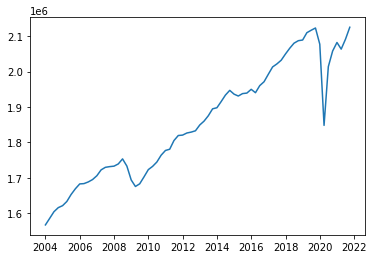

In [6]:
gdp_data = gdpts.copy()
gdp_data.index = gdpts['Date']
plt.plot(gdp_data['GDP'])
plt.show()

# Get predictors from Google Trends

In [114]:
pytrends = TrendReq(hl='en-US', backoff_factor=0.1)


def get_trends(keyword=[''], category='0'):
    """ function to get the google trend for desired keyword and category"""
    kw_list = keyword
    cat = category
    timeframe = '2004-01-01 2022-01-01'
    geo = 'CA'
    gprop = ''

    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    return data, queries

In [115]:
keyword = ["unemployment"]
data, queries = get_trends(keyword = [''], category = '841')

In [116]:
data

,,isPartial
date,,
2004-01-01,49,False
2004-02-01,48,False
2004-03-01,44,False
2004-04-01,47,False
2004-05-01,48,False
...,...,...
2021-09-01,65,False
2021-10-01,65,False
2021-11-01,70,False


### Plot trends

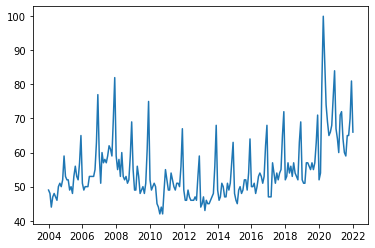

In [117]:
trend_data = data.copy()
plt.plot(trend_data[''])
plt.show()

In [76]:
kw_list = ''
cat = '22'
timeframe = '2004-01-01 2022-01-01'
geo = 'CA'
gprop = ''

pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
data = pytrends.interest_over_time()

ResponseError: The request failed: Google returned a response with code 400.